# <font color = 'indianred'>**Emotion Detection - MultiLabel** </font>

**Plan**

1. Set Environment
2. Load Dataset
3. Load Pre-trained Tokenizer
4. Train Model
     1. Compute Metric Function <br>
     2. Training Arguments <br>
     3. Specify Model
     4. Instantiate Trainer <br>
     5. Setup WandB <br>
     6. Training and Validation






















# <font color = 'indianred'> **1. Setting up the Environment** </font>



In [1]:
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  # Install the latest version of torchtext library quietly without showing output
  # !pip install torchtext -qq
  !pip install transformers evaluate wandb datasets accelerate peft bitsandbytes -U -qq ## NEW LINES ##
  basepath = '/content/drive/MyDrive/data/'
else:
  basepath = '/home/harpreet/Insync/google_drive_shaannoor/data'

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.3/277.3 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 45.7 MB

<font color = 'indianred'> *Load Libraries* </font>

In [2]:
# standard data science librraies for data handling and v isualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

import torch
import torch.nn as nn
from datasets import load_dataset
from transformers import (
    TrainingArguments,
    Trainer,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    BitsAndBytesConfig,
)

import wandb
import evaluate

In [3]:
from peft import (
    TaskType,
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model,
)

# <font color = 'indianred'> **2. Load_Dataset** </font>

In [4]:
base_folder = Path(basepath)
data_folder = base_folder / 'datasets/my_project'
model_folder = base_folder / 'models/nlp_spring_2024/my_project'

In [5]:
model_folder.mkdir(exist_ok=True, parents=True)
data_folder.mkdir(exist_ok=True, parents=True)

In [6]:
# Load train data
import pandas as pd
train_data = pd.read_csv("/content/drive/MyDrive/data/datasets/train.csv")


In [7]:
# Split features and labels
y = train_data[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love','optimism', 'pessimism', 'sadness', 'surprise', 'trust']].values.astype(float)
X = train_data.drop(columns=['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love','optimism', 'pessimism', 'sadness', 'surprise', 'trust'])

# Split data into train, test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Further split train data into train and validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.95, random_state=1)  # 0.25 x 0.8 = 0.2


In [8]:

# Create a subset of the training data
subset_size = 1000  # Define the size of the subset
X_train = X_train[:subset_size]
y_train = y_train[:subset_size]

In [9]:
# Convert X_train, X_valid to lists
X_train_list = list(X_train['Tweet'])
X_valid_list = list(X_valid['Tweet'])
X_test_list = list(X_test['Tweet'])

In [10]:
# imports from Huggingface ecosystem
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import PreTrainedModel, PretrainedConfig
from transformers import TrainingArguments, Trainer
from datasets import Dataset
import evaluate

In [11]:
# Create Datasets
train_set = Dataset.from_dict({
    'text': X_train_list,
    'labels': y_train
})

valid_set = Dataset.from_dict({
    'text': X_valid_list,
    'labels': y_valid
})

test_set = Dataset.from_dict({
    'text': X_test_list,
    'labels': y_test
})

In [12]:


# Create DatasetDict
from datasets import DatasetDict

emotion_data = DatasetDict({
    "train": train_set,
    "valid": valid_set
})

In [13]:
#emotion_data = load_dataset('harpreetmann/train_emotion_spring_2024')

In [13]:
emotion_data['train'][0:2]

{'text': ['#soywax limited edition horror candles going up @scentedscreams! Follow us for all the latest news!! #horror',
  "@nadinekellman yes I can. Don't discourage me."],
 'labels': [[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]]}

In [14]:
labels = ['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'love',
 'optimism',
 'pessimism',
 'sadness',
 'surprise',
 'trust']

# <font color = 'indianred'>**3. Load pre-trained Tokenizer**</font>



In [15]:
from huggingface_hub import notebook_login
notebook_login()


In [16]:
checkpoint = "intfloat/e5-mistral-7b-instruct"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
#tokenizer.padding_side = "left"
#tokenizer.pad_token = tokenizer.eos_token


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/981 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [17]:
def tokenize_fn(batch):
    return tokenizer(text = batch["text"], truncation=True)

<font color = 'indianred'> *Use map function to apply tokenization to all splits*

In [18]:
tokenized_dataset= emotion_data.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(
    ['text']
)
#tokenized_dataset.set_format(type='torch')

Map:   0%|          | 0/308 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/5871 [00:00<?, ? examples/s]

In [19]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 308
    })
    valid: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 5871
    })
})

#  <font color = 'indianred'> **4. Model Training**

##  <font color = 'indianred'> **4.1. compute_metrics function** </font>



In [20]:
accuracy_metric = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # logits= logits[0]
    # print(logits.shape)
    preds = (logits > 0).astype(int)
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy':accuracy['accuracy'],
            }

## <font color = 'indianred'> **4.2. Training Arguments**</font>







In [21]:
# Define the directory where model checkpoints will be saved
run_name = "Alibaba-NLP/gte-Qwen1.5-7B-instruct_qlora_im"
base_folder = Path(basepath)
model_folder = base_folder / "models"/run_name
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=5,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    # gradient_accumulation_steps=4,

    weight_decay=0.1,  # Apply L2 regularization to prevent overfitting
    learning_rate=5e-6,  # Step size for the optimizer during training
    lr_scheduler_type='linear',
    warmup_steps=0,  # Number of warmup steps for the learning rate scheduler
    optim='paged_adamw_32bit',  # Optimizer,
    max_grad_norm = 1.0,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name=run_name,  # Experiment name for Weights & Biases

    #fp16=True,
    bf16=True
    #tf32= False
)


## <font color = 'indianred'> **4.3. Specify Model**</font>

In [23]:
# BitsAndBytesConfig??

In [22]:
bnb_config = BitsAndBytesConfig(
  load_in_4bit=True,
  llm_int8_skip_modules = ['score'],
  bnb_4bit_quant_type="nf4",
  bnb_4bit_use_double_quant=True,
  bnb_4bit_compute_dtype=torch.bfloat16
)

In [23]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels=11,
                                                           problem_type="multi_label_classification",
                                                           quantization_config=bnb_config)

model = prepare_model_for_kbit_training(model)

config = AutoConfig.from_pretrained(checkpoint)
id2label= {id_: label_ for id_, label_ in enumerate(labels)}
label2id = {label_: id_ for id_, label_ in enumerate(labels)}
config.id2label = id2label
config.label2id = label2id
model.config = config
model


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/23.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.28G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of MistralForSequenceClassification were not initialized from the model checkpoint at intfloat/e5-mistral-7b-instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MistralForSequenceClassification(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=2)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): M

In [24]:
#model.config.pad_token_id = tokenizer.pad_token_id
model.config.pad_token_id = 2
model.config

MistralConfig {
  "_name_or_path": "intfloat/e5-mistral-7b-instruct",
  "architectures": [
    "MistralModel"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadness": 8,
    "surprise": 9,
    "trust": 10
  },
  "max_position_embeddings": 32768,
  "model_type": "mistral",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pad_token_id": 2,
  "rms_norm_eps": 1e-05,
  "rope_theta": 10000.0,
  "sliding_window": 4096,
  "tie_word_emb

In [27]:
#from transformers import DataCollatorWithPadding
#data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [28]:
# prompt: pass two observations from tokenized dataset to datacollatior

#batch = [tokenized_dataset['train'][0], tokenized_dataset['train'][1]]
#batch = data_collator(batch)
#batch


In [29]:
#input_ids = batch['input_ids']
#input_ids

In [30]:
#pad_token_id = 2

In [31]:
#sequence_lengths = torch.eq(input_ids, pad_token_id).int().argmax(-1) - 1

In [32]:
#sequence_lengths

In [25]:
import re
model_modules = str(model.modules)
pattern = r'\((\w+)\): Linear'
linear_layer_names = re.findall(pattern, model_modules)

names = []
# Print the names of the Linear layers
for name in linear_layer_names:
    names.append(name)
target_modules = list(set(names))
target_modules

['score',
 'o_proj',
 'v_proj',
 'up_proj',
 'down_proj',
 'q_proj',
 'k_proj',
 'gate_proj']

In [34]:
# LoraConfig??

In [26]:
mistral_peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=128,
    lora_alpha=256,
    lora_dropout=0.01,
    bias="lora_only",
    modules_to_save = ['score'],
    target_modules = ['v_proj',  'q_proj',  'up_proj', 'o_proj', 'down_proj', 'gate_proj','k_proj'])

mistral_qlora_model = get_peft_model(model, mistral_peft_config )
#mistral_qlora_model.config.pad_token_id = tokenizer.pad_token_id
#mistral_qlora_model.resize_token_embeddings(len(tokenizer))
mistral_qlora_model.print_trainable_parameters()

trainable params: 335,589,376 || all params: 7,446,294,528 || trainable%: 4.506796967781718


In [27]:
mistral_peft_config.target_modules

{'down_proj', 'gate_proj', 'k_proj', 'o_proj', 'q_proj', 'up_proj', 'v_proj'}

In [28]:
mistral_qlora_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): MistralForSequenceClassification(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=2)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.01, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=128, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=128, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): l

##  <font color = 'indianred'> **4.4 Custom Trainer**</font>



In [29]:
def calculate_pos_weights(dataset):
    # Initialize counters for all labels
    num_labels = len(dataset['train']['labels'][0])
    total_positives = [0] * num_labels
    total_negatives = [0] * num_labels

    # Count positives and negatives for each label
    for label_array in dataset['train']['labels']:
        for i, label in enumerate(label_array):
            if label == 1:
                total_positives[i] += 1
            else:
                total_negatives[i] += 1

    # Calculate pos_weight for each label
    pos_weight = [total_negatives[i] / max(total_positives[i], 1) for i in range(num_labels)]
    return torch.tensor(pos_weight)

# Calculate the pos_weight using the training set
pos_weights = calculate_pos_weights(tokenized_dataset)


In [30]:
pos_weights

tensor([ 1.7748,  5.1600,  1.8257,  4.5000,  1.7257,  7.3243,  2.0196,  8.3333,
         2.3846, 18.2500, 24.6667])

In [31]:
pos_weights= torch.tensor([2., 3., 2., 2., 2., 3., 2., 3., 2., 4., 4.])

In [32]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels").float()  # Ensure labels are float for BCE loss
        outputs = model(**inputs)
        logits = outputs.get("logits")

        device = next(model.parameters()).device

        loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weights.to(device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [33]:
mistral_qlora_model.config

MistralConfig {
  "_name_or_path": "intfloat/e5-mistral-7b-instruct",
  "architectures": [
    "MistralModel"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadness": 8,
    "surprise": 9,
    "trust": 10
  },
  "max_position_embeddings": 32768,
  "model_type": "mistral",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pad_token_id": 2,
  "rms_norm_eps": 1e-05,
  "rope_theta": 10000.0,
  "sliding_window": 4096,
  "tie_word_emb

In [34]:
trainer = CustomTrainer(
    model=mistral_qlora_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,

)

## <font color = 'indianred'> **4.5 Setup WandB**</font>

In [35]:
wandb.login()
%env WANDB_PROJECT = MTEB_kaggle_S2024

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


env: WANDB_PROJECT=MTEB_kaggle_S2024


## <font color = 'indianred'> **4.6. Start Training**</font>

In [ ]:
#trainer??

In [36]:
trainer.train()  # start training

wandb: Currently logged in as: likith-gv. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
20,1.179700,0.918058,0.429105,0.300784,0.034577
40,0.507400,0.888197,0.470743,0.340733,0.061829


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=T

TrainOutput(global_step=50, training_loss=0.7487327671051025, metrics={'train_runtime': 503.2368, 'train_samples_per_second': 3.06, 'train_steps_per_second': 0.099, 'total_flos': 3797127188054016.0, 'train_loss': 0.7487327671051025, 'epoch': 5.0})

## <font color = 'indianred'> **4.7. Validation**</font>


In [37]:
eval_results = trainer.evaluate(tokenized_dataset["valid"])

In [38]:
eval_results

{'eval_loss': 0.8881968259811401,
 'eval_f1_micro': 0.4707433323192374,
 'eval_f1_macro': 0.3407328711561941,
 'eval_accuracy': 0.06182933060807358,
 'eval_runtime': 65.0869,
 'eval_samples_per_second': 90.203,
 'eval_steps_per_second': 2.827,
 'epoch': 5.0}

In [39]:
wandb.log({"eval_accuracy": eval_results["eval_accuracy"], "eval_loss": eval_results["eval_loss"],
"eval_f1_micro": eval_results["eval_f1_micro"], "eval_f1_macro": eval_results["eval_f1_macro"]})

###  <font color = 'indianred'> **Check Confusion Matrix**</font>




In [40]:
# Use the trainer to generate predictions on the tokenized validation dataset.
# The resulting object, valid_output, will contain the model's logits (raw prediction scores) for each input in the validation set.
valid_output = trainer.predict(tokenized_dataset["valid"])

In [41]:
valid_output.predictions.shape

(5871, 11)

In [42]:
predictions_valid = (valid_output.predictions > 0).astype(int)
labels_valid = valid_output.label_ids.astype(int)

In [43]:
predictions_valid.shape

(5871, 11)

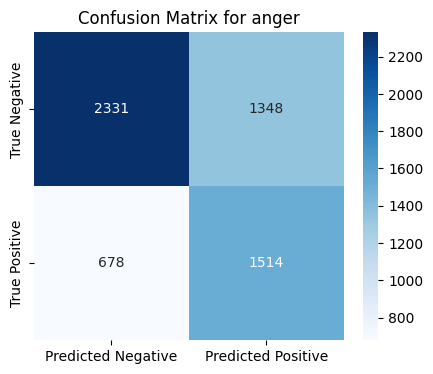

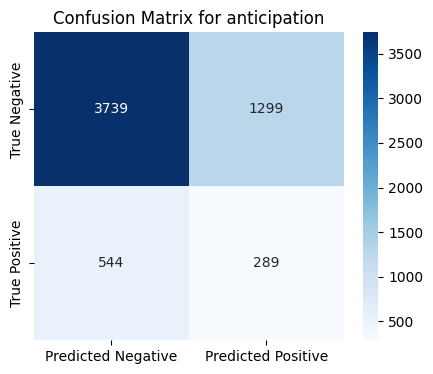

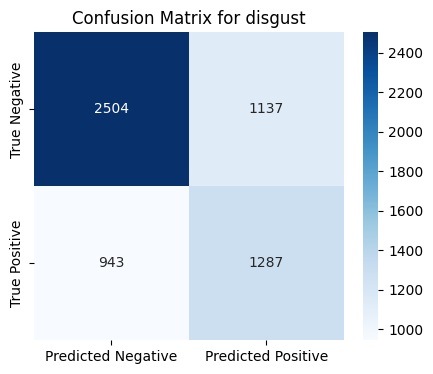

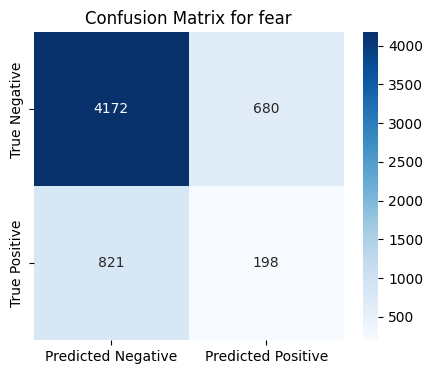

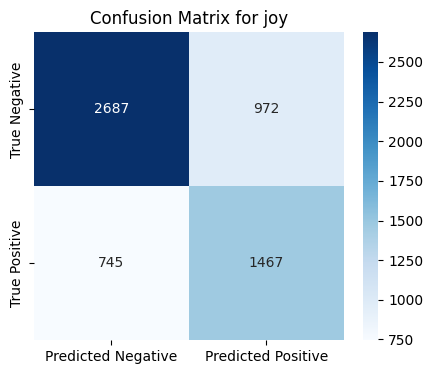

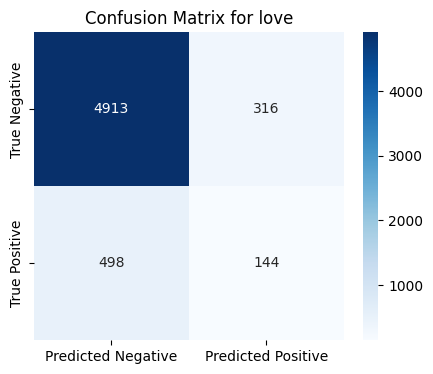

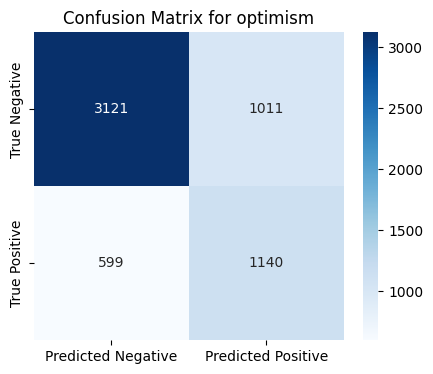

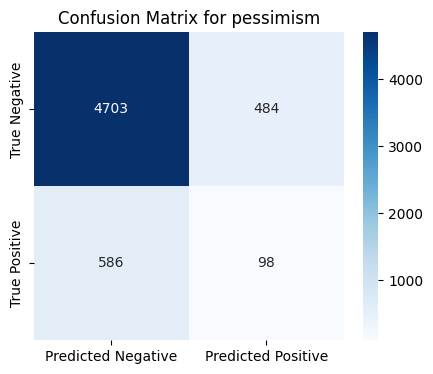

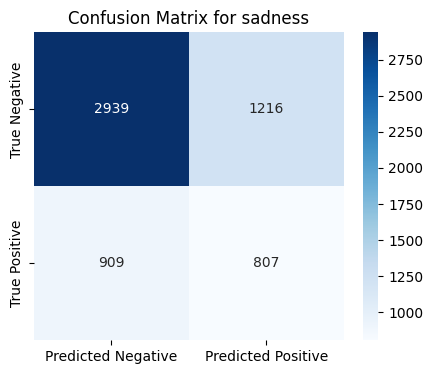

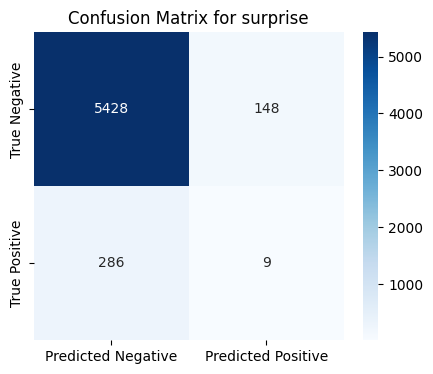

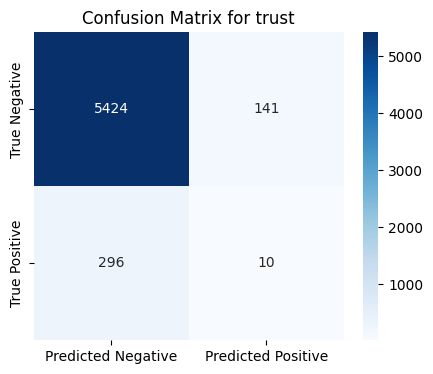

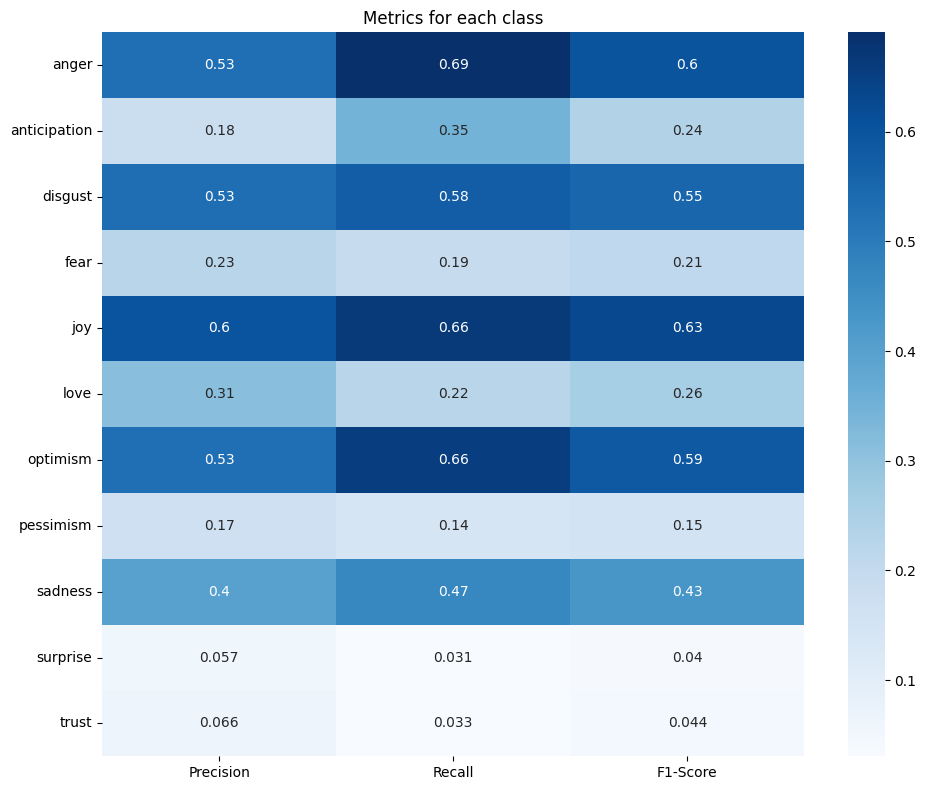

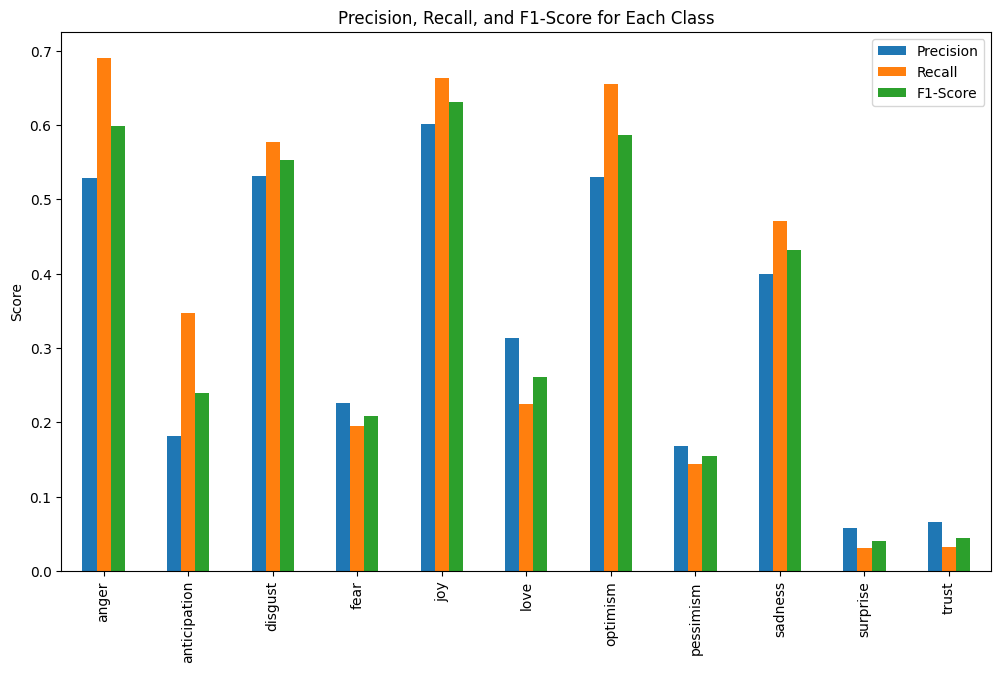

In [44]:
y_true = labels_valid
y_pred = predictions_valid
class_names = labels

mcm = multilabel_confusion_matrix(y_true, y_pred,)

# 1. Individual Heatmaps
for idx, matrix in enumerate(mcm):
    plt.figure(figsize=(5, 4))
    sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['True Negative', 'True Positive'])
    plt.title(f'Confusion Matrix for {class_names[idx]}')
    plt.show()

# 2. Aggregate Metrics Heatmap
precision_per_class = precision_score(y_true, y_pred, average=None)
recall_per_class = recall_score(y_true, y_pred, average=None)
f1_per_class = f1_score(y_true, y_pred, average=None)

metrics_df = pd.DataFrame({
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class
}, index=class_names)

plt.figure(figsize=(10, 8))
# sns.heatmap(metrics_df, annot=True, cmap='Blues')
# plt.title('Metrics for each class')
# plt.show()

ax = sns.heatmap(metrics_df, annot=True, cmap='Blues')
plt.title('Metrics for each class')
plt.tight_layout()  # Adjust layout to not cut off edges

# Log the heatmap to wandb
wandb.log({"Metrics Heatmap": wandb.Image(ax.get_figure())})
plt.show()

# 3. Histogram of Metrics
metrics_df.plot(kind='bar', figsize=(12, 7))
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score for Each Class')
plt.show()




In [45]:
wandb.finish()

eval/accuracy,▁██
eval/f1_macro,▁██
eval/f1_micro,▁██
eval/loss,█▁▁
eval/runtime,▁█▇
eval/samples_per_second,█▁▂
eval/steps_per_second,█▁▁
eval_accuracy,▁
eval_f1_macro,▁
eval_f1_micro,▁
eval_loss,▁


In [46]:
from huggingface_hub import notebook_login
notebook_login()

In [47]:
mistral_qlora_model.push_to_hub("glikithvinayaka/MTEB_QLORA_emotion_detection")

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


adapter_model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/glikithvinayaka/MTEB_QLORA_emotion_detection/commit/e55aa932ec840c5c4512590b9cd62e3c4410c11c', commit_message='Upload model', commit_description='', oid='e55aa932ec840c5c4512590b9cd62e3c4410c11c', pr_url=None, pr_revision=None, pr_num=None)

In [48]:
mistral_qlora_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): MistralForSequenceClassification(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=2)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.01, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=128, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=128, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): l

# Test Set Predictions

In [49]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForSequenceClassification, AutoTokenizer



peft_model_id = "glikithvinayaka/MTEB_QLORA_emotion_detection"
config = PeftConfig.from_pretrained(peft_model_id)
config.base_model_name_or_path
base_model = AutoModelForSequenceClassification.from_pretrained(config.base_model_name_or_path,
                                                                 num_labels=11,
                                                                 problem_type="multi_label_classification"
                                                                #quantization_config=bnb_config
                                                                )
base_model = prepare_model_for_kbit_training(base_model)
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

adapter_config.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of MistralForSequenceClassification were not initialized from the model checkpoint at intfloat/e5-mistral-7b-instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
base_model

MistralForSequenceClassification(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=2)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    

In [51]:
#Load the Lora model
inference_model = PeftModel.from_pretrained(base_model, peft_model_id)

adapter_model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

In [52]:
inference_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): MistralForSequenceClassification(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=2)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.01, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=128, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=128, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Line

In [53]:
import pandas as pd
from datasets import Dataset


# Load test data
test_data = pd.read_csv("/content/drive/MyDrive/data/datasets/test.csv")

# Preprocess test data
X_test_cleaned = test_data['Tweet'].tolist()

# Replace 'NONE' with 0 in the label columns
label_columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
test_data[label_columns] = test_data[label_columns].replace('NONE', 0).to_numpy(dtype=np.int64)


In [54]:
# Convert label columns to int type
test_data[label_columns] = test_data[label_columns].astype(int)

# Create Dataset object for test set
testset = Dataset.from_dict({
    'text': X_test_cleaned,
    'labels': test_data[label_columns].values.tolist()
})


In [55]:
def tokenize_fn(batch):
    return tokenizer(text = batch["text"], truncation=True)

In [ ]:
tokenized_dataset= testset.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(
    ['text']
)
# tokenized_dataset.set_format(type='torch')

In [57]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def calculate_metrics_TEST(eval_pred):
    # Unpack logits and labels
    logits, labels = eval_pred

    # Convert logits and labels to FloatTensor and LongTensor respectively
    logits = logits.float()
    labels = labels.long()

    # Convert logits to numpy array
    logits_np = logits.detach().cpu().numpy()

    # Convert logits to probabilities using sigmoid function
    probabilities = 1 / (1 + np.exp(-logits_np))

    # Convert probabilities to binary predictions using a threshold of 0.25
    predictions = (probabilities >= 0.25).astype(int)

    # Convert labels to numpy array
    labels_np = labels.detach().cpu().numpy()

    # Calculate accuracy and F1 score
    accuracy = accuracy_score(labels_np.flatten(), predictions.flatten())
    f1 = f1_score(labels_np, predictions, average='macro', zero_division=0)

    # Return metrics
    return {'accuracy': accuracy, 'f1': f1, 'predictions': predictions}


In [61]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, hamming_loss

def compute_metrics_test(eval_pred):
    logits, labels = eval_pred
    # Apply sigmoid to the logits to get probabilities
    probabilities = 1 / (1 + np.exp(-logits))
    # Choosing appropriate threshold and converting into predictions
    predictions = (probabilities >= 0.46).astype(int)
    #print(np.average(probabilities))

    # Metrics calculation
    accuracy = accuracy_score(labels.flatten(), predictions.flatten())
    f1 = f1_score(labels, predictions, average='macro', zero_division=0)
    precision = precision_score(labels, predictions, average='macro', zero_division=0)
    recall = recall_score(labels, predictions, average='macro', zero_division=0)
    hamming = hamming_loss(labels, predictions)

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'hamming_loss': hamming,
#Returining Predictions from here to create the datafarme later
        'predictions': predictions
    }


In [62]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=16,
    do_train=False,
    do_eval=False,
    remove_unused_columns=False,
    report_to=[]
)

In [66]:
# Create the trainer instance
trainer = CustomTrainer(
    model=inference_model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_test,
)

In [67]:
# Make predictions on the test dataset
predictions = trainer.predict(tokenized_dataset)


In [68]:
predictions

PredictionOutput(predictions=array([[-0.49414062,  0.16210938,  0.44140625, ..., -5.        ,
        -2.421875  , -3.640625  ],
       [ 3.6875    , -0.68359375,  1.40625   , ..., -2.40625   ,
        -1.5390625 , -3.046875  ],
       [ 1.0390625 ,  1.859375  ,  2.46875   , ...,  1.6015625 ,
        -2.09375   , -0.99609375],
       ...,
       [-0.23925781, -1.0078125 , -0.23632812, ..., -0.9375    ,
        -2.171875  , -2.25      ],
       [-2.5       , -0.38671875, -3.96875   , ...,  2.90625   ,
        -1.9296875 , -3.421875  ],
       [-0.76953125,  0.7421875 ,  0.8671875 , ..., -0.14941406,
        -4.3125    , -2.46875   ]], dtype=float32), label_ids=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), metrics={'test_loss': 0.5689558386802673, 'test_accuracy': 0.7148037602164635, 'test_f1': 0.0, 'test_precision': 0.0, 'test_re

In [69]:
len(predictions.predictions)

3259

In [70]:
# Post-process predictions
predicted_labels = np.argmax(predictions.predictions, axis=1)


In [71]:
predictions

PredictionOutput(predictions=array([[-0.49414062,  0.16210938,  0.44140625, ..., -5.        ,
        -2.421875  , -3.640625  ],
       [ 3.6875    , -0.68359375,  1.40625   , ..., -2.40625   ,
        -1.5390625 , -3.046875  ],
       [ 1.0390625 ,  1.859375  ,  2.46875   , ...,  1.6015625 ,
        -2.09375   , -0.99609375],
       ...,
       [-0.23925781, -1.0078125 , -0.23632812, ..., -0.9375    ,
        -2.171875  , -2.25      ],
       [-2.5       , -0.38671875, -3.96875   , ...,  2.90625   ,
        -1.9296875 , -3.421875  ],
       [-0.76953125,  0.7421875 ,  0.8671875 , ..., -0.14941406,
        -4.3125    , -2.46875   ]], dtype=float32), label_ids=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), metrics={'test_loss': 0.5689558386802673, 'test_accuracy': 0.7148037602164635, 'test_f1': 0.0, 'test_precision': 0.0, 'test_re

In [72]:
import pandas as pd

# Extract the 'test_predictions' array from the predictions dictionary
test_predictions_array = predictions.metrics['test_predictions']

# Create a DataFrame from the 'test_predictions' array
test_predictions_df = pd.DataFrame(test_predictions_array)

# Print or further manipulate the DataFrame as needed
print(test_predictions_df)


      0   1   2   3   4   5   6   7   8   9   10
0      0   1   1   0   0   0   0   0   0   0   0
1      1   0   1   0   1   0   0   1   0   0   0
2      1   1   1   0   0   0   0   1   1   0   0
3      1   1   1   0   0   0   0   1   0   0   0
4      1   0   1   0   1   0   0   0   1   0   0
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
3254   0   0   0   0   0   0   0   1   0   0   0
3255   0   0   0   1   0   0   1   0   0   0   1
3256   0   0   0   0   0   0   0   0   0   0   0
3257   0   0   0   1   1   1   1   0   1   0   0
3258   0   1   1   0   0   0   0   0   1   0   0

[3259 rows x 11 columns]


In [73]:
import pandas as pd

# Load test.csv to get the first column
test_df = pd.read_csv("/content/drive/MyDrive/data/datasets/test.csv")

first_column = test_df.iloc[:, 0]

# Convert eval_predictions to a DataFrame
predictions_df = pd.DataFrame(test_predictions_df)

# Concatenate the first column with predictions_df
result_df = pd.concat([first_column, predictions_df], axis=1)
print(result_df)


              ID  0  1  2  3  4  5  6  7  8  9  10
0     2018-01559  0  1  1  0  0  0  0  0  0  0   0
1     2018-03739  1  0  1  0  1  0  0  1  0  0   0
2     2018-00385  1  1  1  0  0  0  0  1  1  0   0
3     2018-03001  1  1  1  0  0  0  0  1  0  0   0
4     2018-01988  1  0  1  0  1  0  0  0  1  0   0
...          ... .. .. .. .. .. .. .. .. .. ..  ..
3254  2018-03848  0  0  0  0  0  0  0  1  0  0   0
3255  2018-00416  0  0  0  1  0  0  1  0  0  0   1
3256  2018-03717  0  0  0  0  0  0  0  0  0  0   0
3257  2018-03504  0  0  0  1  1  1  1  0  1  0   0
3258  2018-00115  0  1  1  0  0  0  0  0  1  0   0

[3259 rows x 12 columns]


In [74]:
result_df.to_csv('/content/drive/MyDrive/data/datasets/submission.csv', index=False)